## **SpO2 and Heart Rate measurement using smartphone camera**

### Poorva Bedmutha

<hr>

### **Determination** of SpO2 and heartrate using smartphone camera

#### **Introduction**
This notebook largely bases its implementation on the paper ["Physiological Parameter Monitoring from Optical
Recordings With a Mobile Phone"](https://sci-hub.st/https://ieeexplore.ieee.org/abstract/document/5963704) by Scully et. al. 

#### **Importing Libraries**
The following libraries are needed. They can be installed by pip install <lib-name> 
*   cv2 for image operations
*   os for file reading
*   numpy for array based operations
*   statistics for mean function (can use np.mean too)
*   matplotlib for plotting
*   scipy.signal for signal processing
   

In [1]:
import cv2
import os
import numpy as np
from statistics import mean 
import matplotlib.pyplot as plt
import scipy.signal

#### **File Structure**
All files are names as "*lash_xx_yy" where xx is the SpO<sub>2</sub> reading and yy is the heart rate. All data is matched using oximeter readings taken simultaneously. The readings as spread across age, brightness and gender.

In [2]:
# Read all files

data_folder = "./Flash_Train_Data/"
files = os.listdir(data_folder)
files

['flash_96_85.mp4',
 'flash_97_90.mp4',
 'flash_98_71.mp4',
 'flash_98_75.mp4',
 'flash_98_78.mp4',
 'flash_98_80.mp4',
 'flash_98_81.mp4',
 'flash_98_86.mp4',
 'flash_98_88.mp4',
 'flash_98_90.mp4',
 'flash_98_93.mp4',
 'flash_98_97.mp4',
 'flash_99_104.mp4',
 'flash_99_106.mp4',
 'flash_99_112.mp4',
 'flash_99_65.mp4',
 'flash_99_68.mp4',
 'flash_99_71.mp4',
 'flash_99_74.mp4',
 'flash_99_76.mp4',
 'flash_99_77.mp4',
 'flash_99_81.mp4',
 'flash_99_83.mp4',
 'flash_99_84.mp4',
 'flash_99_85.mp4',
 'flash_99_90.mp4',
 'flash_99_95.mp4',
 'flash_99_99.mp4',
 'slash_99_81.mp4']

### Extracting output values from file name

This is done by taking digits from specific indices to get spo2 and heart rate respectively

In [3]:
def y_list(files):
    for i in range(len(files)):
        file_name = files[i]
        spo2_y.append(int(file_name[6:8]))
        hr_y.append(int(file_name[9:-4]))
    return spo2_y, hr_y

In [4]:
spo2_y = []
hr_y = []

spo2_y, hr_y = y_list(files)
spo2_y, hr_y

([96,
  97,
  98,
  98,
  98,
  98,
  98,
  98,
  98,
  98,
  98,
  98,
  99,
  99,
  99,
  99,
  99,
  99,
  99,
  99,
  99,
  99,
  99,
  99,
  99,
  99,
  99,
  99,
  99],
 [85,
  90,
  71,
  75,
  78,
  80,
  81,
  86,
  88,
  90,
  93,
  97,
  104,
  106,
  112,
  65,
  68,
  71,
  74,
  76,
  77,
  81,
  83,
  84,
  85,
  90,
  95,
  99,
  81])

#### SpO2 definition 

While this is highly inaccurate, for the sake of replicability I keep the formula same. I also tried to add different other features but did not see much improvement and hence discarded their use.

$SpO2 = A + B * [\frac{AC_{red}/DC_{red}}{AC_{blue}/DC_{blue}}]$

Here AC and DC represent the AC and DC component of the signal (video) respectively. The DC value is given by the mean while variance gives the AC.

As per the paper, based on their trials, A = 100 and B = -5 are the best coefficients.

Since we need to calibrate with respect to our data we propose a small tweak. We take the first <i>k</i> values as train samples or known samples and calculate A and B with them using linear regression. We then calculate SpO2 for the remaining samples to check for its correctness.

#### The Processing Function

This function takes in images and calculates the AC/DC values as well as the frame rate for the video. The frames(images) are split into R,G,B channels and their mean and variance is calculated. The ratio of AC/DC for red to blue is referred to as x.

In [5]:
def process(filepath):
    vidcap = cv2.VideoCapture(filepath)
    count = 0
    success = vidcap.isOpened()
    mean_DC_R = []
    mean_DC_B = []
    var_AC_R = []
    var_AC_B = []
    mean_DC_avg = []
    frames = 0

    while success:
        success, image = vidcap.read()

        if success == False:
            break

        img = cv2.resize(image, (320,240))
        r = img.copy()[:,:,2]
        b = img.copy()[:,:,0]
        mean_DC_R.append(r.mean())
        mean_DC_B.append(b.mean())
        mean_DC_avg.append(img.mean())
        var_AC_R.append(r.var())
        var_AC_B.append(b.var())
    
    x = (mean(var_AC_R)/mean(mean_DC_R))/(mean(var_AC_B)/mean(mean_DC_B))
    
    fps = vidcap.get(cv2.CAP_PROP_FPS)

    return x, mean_DC_R, mean_DC_avg, fps

#### Get SpO<sub>2</sub> function

This function takes in the coefficients returned by the linear model trained on the given _k_ files and calculates the SpO<sub>2</sub> value with the AC/DC values of red and blue frames of thr input video.

In [6]:
def get_spo2(x, A=100, B=-5):
    spo2 = A+B*x
    return spo2

#### Get Heart Rate

The heart rate is analogous to the number of peaks in the given video for a particular quantity. Two papers define two signals for this purpose. The function is generic and can take any signal to get heart rate in beats per minute.

In [7]:
def get_hr(signal, fps = 30):
    peaks = scipy.signal.find_peaks(signal)
    npeaks = len(peaks[0])
    hr = 60*npeaks/(len(signal)/fps)
    return hr

#### Calculate all values required for all files 

In [8]:
X = []
DC_R = []
DC_avg = []
frames = []

for file in files:
    x, mean_DC_R, mean_DC_avg, fps = process(os.path.join(data_folder,file))
    X.append(x)
    DC_R.append(mean_DC_R)
    DC_avg.append(mean_DC_avg)
    frames.append(fps)
    print(file, x, fps)

flash_96_85.mp4 0.2551065313810545 29.59697970639149
flash_97_90.mp4 0.7284331546002324 29.593064725383407
flash_98_71.mp4 0.6237785358168543 29.587767063276907
flash_98_75.mp4 0.6044118509848485 29.608710002339215
flash_98_78.mp4 1.0670264080247507 29.585370229428698
flash_98_80.mp4 0.23887025561802605 29.576771709992784
flash_98_81.mp4 0.7177337381072377 29.598452520971644
flash_98_86.mp4 0.7193930526556702 29.58976169891504
flash_98_88.mp4 0.6850321563714015 29.608594702719834
flash_98_90.mp4 0.7744121983290799 29.585765903670215
flash_98_93.mp4 0.9846294921136471 29.59598196179707
flash_98_97.mp4 0.763756541034568 29.596538733427934
flash_99_104.mp4 0.7248219111486287 29.571907548926212
flash_99_106.mp4 1.0906014439786098 29.563449656479893
flash_99_112.mp4 1.0228001104490658 29.528104575996167
flash_99_65.mp4 0.5887459773887708 29.596084857611054
flash_99_68.mp4 1.0094926145908425 29.608783352537543
flash_99_71.mp4 1.291037208271805 29.597543648660874
flash_99_74.mp4 1.14585507989

### Calibration

As discussed above the first k values are taken to calibrate A and B coefficients. These coefficients will be used to find SpO2 for other samples.

In [9]:
k = 18
spo2_cal = spo2_y[:k]
X_train = X[:k]

#### Calculate line fit

The line fit is taken by taking a numpy polyfit of order 1. The coefficients A and B are the intercept and slope respectively.

In [10]:
linear_model = np.polyfit(X_train,spo2_cal,1)
linear_model_fn=np.poly1d(linear_model)
B, A = linear_model
A, B

(96.85096488455778, 1.7050028980809404)

#### Checking the fit

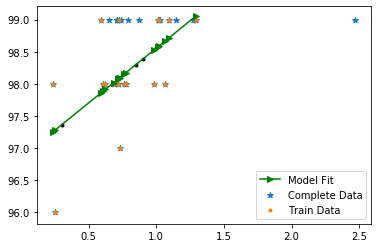

In [11]:
x_s = np.sort(X_train)
plt.plot(x_s,linear_model_fn(x_s),color="green",marker=">")
plt.scatter(X, spo2_y, marker="*")
plt.scatter(X_train, spo2_cal, marker=".")

test_x = np.sort([0.3,0.9, 1,0.85])
plt.scatter(test_x, linear_model_fn(test_x), color="black",marker=".")
plt.legend(['Model Fit','Complete Data','Train Data'])
plt.show()

#### Testing

The sample beyond k are taken for testing the fit on real life data

In [12]:
X_test = X[k:]
y_test = spo2_y[k:]

In [13]:
y_pred = get_spo2(np.array(X_test), A, B)
print("Ground Truth\tPredicted Values")
for i in range(len(X_test)):
    print(y_test[i],"\t\t" ,np.round(y_pred[i],2))

Ground Truth	Predicted Values
99 		 98.8
99 		 97.96
99 		 98.05
99 		 99.02
99 		 98.06
99 		 98.34
99 		 98.06
99 		 101.06
99 		 98.11
99 		 98.2
99 		 98.6


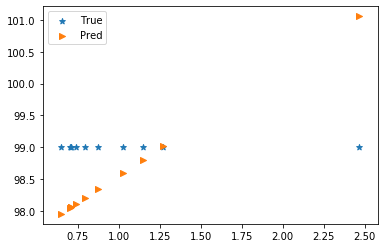

In [14]:
plt.scatter(X_test, y_test, marker="*")
plt.scatter(X_test, y_pred, marker=">")
plt.legend(["True","Pred"])
plt.show()

In [15]:
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
mae = np.mean(np.abs(y_test - y_pred))
print("RMSE: ",rmse)
print("MAE:  ", mae)

RMSE:  0.9557913444207976
MAE:   0.808012045418084


#### Classification of SpO<sub>2<sub>
The readings are classified into three categories namely normal, borderline and warning based on their SpoO<sub>2</sub>
*    Normal: > 94%
*    Borderline: 90% to 94%
*    Warning: < 90%
                   
Since we did not have data other than normal, I have implemented the classification code but the results will not be a correct measure of the classification

In [16]:
status_test = np.array(y_test)
status_pred = np.array(y_pred)
# Normal SpO2 Range
status_test[status_test > 94] = 1
status_pred[status_pred > 94] = 1
# Borderline SpO2 Range
status_test[status_test > 90] = 0
status_pred[status_pred > 90] = 0
# Warning SpO2 Range (Everything which is not normal or borderline)
status_test[status_test > 2] = -1
status_pred[status_pred > 2] = -1

status_pred, status_test

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(status_test, status_pred))
print(confusion_matrix(status_test, status_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        11

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

[[11]]


### Heart Rate

Text(0, 0.5, 'Signal Value')

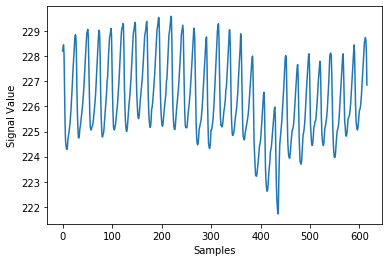

In [18]:
# An example

plt.plot(DC_R[3])
plt.xlabel("Samples")
plt.ylabel("Signal Value")

#### Getting heart rate

We find the peaks per samples in two cases:
1. Mean of the red DC component per frame
2. Mean of the average DC component per frame

In [19]:
hr_r = []
hr_avg = []
print("Mean Red\tMean Average\tActual")
for i in range(len(DC_avg)):
    hr_r.append(get_hr(DC_R[i]))
    hr_avg.append(get_hr(DC_avg[i]))
    print(np.round(hr_r[i]),"\t\t",np.round(hr_avg[i]),"bpm\t", hr_y[i], "bpm")
    
hr_r = np.array(hr_r)
hr_avg = np.array(hr_avg)

Mean Red	Mean Average	Actual
89.0 		 91.0 bpm	 85 bpm
137.0 		 95.0 bpm	 90 bpm
158.0 		 146.0 bpm	 71 bpm
85.0 		 82.0 bpm	 75 bpm
113.0 		 122.0 bpm	 78 bpm
75.0 		 101.0 bpm	 80 bpm
118.0 		 109.0 bpm	 81 bpm
87.0 		 87.0 bpm	 86 bpm
94.0 		 94.0 bpm	 88 bpm
152.0 		 125.0 bpm	 90 bpm
81.0 		 87.0 bpm	 93 bpm
101.0 		 95.0 bpm	 97 bpm
112.0 		 104.0 bpm	 104 bpm
113.0 		 113.0 bpm	 106 bpm
115.0 		 115.0 bpm	 112 bpm
97.0 		 76.0 bpm	 65 bpm
96.0 		 82.0 bpm	 68 bpm
93.0 		 76.0 bpm	 71 bpm
103.0 		 95.0 bpm	 74 bpm
103.0 		 87.0 bpm	 76 bpm
98.0 		 88.0 bpm	 77 bpm
95.0 		 95.0 bpm	 81 bpm
84.0 		 97.0 bpm	 83 bpm
104.0 		 101.0 bpm	 84 bpm
94.0 		 85.0 bpm	 85 bpm
148.0 		 110.0 bpm	 90 bpm
95.0 		 95.0 bpm	 95 bpm
105.0 		 127.0 bpm	 99 bpm
128.0 		 120.0 bpm	 81 bpm


### Calculating error in HR

In [20]:
rmse = np.sqrt(np.mean((hr_y - hr_r)**2))
mae = np.mean(np.abs(hr_y - hr_r))
print("Red Component Mean")
print("RMSE: ",rmse)
print("MAE:  ", mae)

Red Component Mean
RMSE:  30.69781146986821
MAE:   22.166471427704902


In [21]:
rmse = np.sqrt(np.mean((hr_y - hr_avg)**2))
mae = np.mean(np.abs(hr_y - hr_avg))
print("Red Component Mean")
print("RMSE: ",rmse)
print("MAE:  ", mae)

Red Component Mean
RMSE:  22.483523214177893
MAE:   15.593829740631096
